In [1]:
!pip install tensorflow-recommenders --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 3.0 MB/s eta 0:00:00


In [2]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [3]:
import os
import pprint
import tempfile

from typing import Dict, Text
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs
from tensorflow.keras import models, layers

In [4]:
ratings = pd.read_csv("/content/ratings.csv")
movies = pd.read_csv("/content/movies.csv")

# Merge genres into ratings dataset
ratings = pd.merge(ratings, movies[["movieId", "genres"]], on="movieId", how="left")

In [5]:
ratings.head()

,userId,movieId,rating,timestamp,genres
0,1,1,4.0,964982703,Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Comedy|Romance
2,1,6,4.0,964982224,Action|Crime|Thriller
3,1,47,5.0,964983815,Mystery|Thriller
4,1,50,5.0,964982931,Crime|Mystery|Thriller


In [47]:
# ratings_sample = ratings.sample(1000, random_state=42)
# print(f"\nUsing a sample of {1000} ratings for initial testing")

# movie_sample = movies.sample(1000, random_state=42)
# print(f"\nUsing a sample of {1000} movies for initial testing")

# Convert the sample to TensorFlow dataset
# ratings_tf = tf.data.Dataset.from_tensor_slices(ratings_sample.to_dict("list"))
# movies_tf = tf.data.Dataset.from_tensor_slices(movie_sample.to_dict("list"))
ratings_tf = tf.data.Dataset.from_tensor_slices(ratings.to_dict("list"))
movies_tf = tf.data.Dataset.from_tensor_slices(movies.to_dict("list"))

In [48]:
ratings.dtypes

,0
userId,int64
movieId,int64
rating,float64
timestamp,int64
genres,object


In [49]:
movies.dtypes

,0
movieId,int64
title,object
genres,object


**Query Tower**

User Model representing User and its rating

In [50]:
# ========================
# USER TOWER
# ========================
class UserTower(tf.keras.Model):
    def __init__(self, dataset, embedding_dim=64):
        super().__init__()
        self.embedding_dim = embedding_dim

        self.user_id_vocab = tf.keras.layers.IntegerLookup()
        self.user_id_vocab.adapt(dataset.map(lambda x: x["userId"]))

        self.movie_id_vocab = tf.keras.layers.IntegerLookup()
        self.movie_id_vocab.adapt(dataset.map(lambda x: x["movieId"]))

        self.rating_norm = tf.keras.layers.Normalization(axis=None)
        self.rating_norm.adapt(dataset.map(lambda x: tf.cast(x["rating"], tf.float32)))

        self.user_id_embedding = models.Sequential([
            self.user_id_vocab,
            layers.Embedding(self.user_id_vocab.vocabulary_size(), embedding_dim)
        ])

        self.movie_id_embedding = models.Sequential([
            self.movie_id_vocab,
            layers.Embedding(self.movie_id_vocab.vocabulary_size(), embedding_dim)
        ])

    # def call(self, inputs):
    #     user_embedding = self.user_id_embedding(inputs["userId"])
    #     movie_embedding = self.movie_id_embedding(inputs["movieId"])
    #     rating_feature = self.rating_norm(tf.cast(inputs["rating"], tf.float32))
    #     rating_feature = tf.reshape(rating_feature, [-1, 1])
    #     return tf.concat([user_embedding, movie_embedding, rating_feature], axis=1)
    def call(self, inputs):
      user_embedding = self.user_id_embedding(inputs["userId"])        # shape: [batch, 1, embedding_dim]
      movie_embedding = self.movie_id_embedding(inputs["movieId"])     # shape: [batch, 1, embedding_dim]

      rating_feature = tf.cast(inputs["rating"], tf.float32)
      rating_feature = self.rating_norm(rating_feature)                # shape: [batch, 1]
      rating_feature = tf.expand_dims(rating_feature, axis=-1)         # shape: [batch, 1, 1]

      return tf.concat([user_embedding, movie_embedding, rating_feature], axis=-1)

**Testing query tower**

In [51]:
# Test code
if __name__ == "__main__":
    data = {
        "userId": [1, 2, 1],
        "movieId": [1, 2, 3],
        "rating": [4, 5, 3]
    }

    dataset = tf.data.Dataset.from_tensor_slices(data)
    print("Dataset:", dataset)

    user_tower = UserTower(dataset)

    example = {
        "userId": tf.constant([1]),
        "movieId": tf.constant([1]),
        "rating": tf.constant([4])
    }

    user_embeddings = user_tower(example)
    print("\nUser embeddings shape:", user_embeddings.shape)
    print("User embeddings:", user_embeddings)

Dataset: <_TensorSliceDataset element_spec={'userId': TensorSpec(shape=(), dtype=tf.int32, name=None), 'movieId': TensorSpec(shape=(), dtype=tf.int32, name=None), 'rating': TensorSpec(shape=(), dtype=tf.int32, name=None)}>

User embeddings shape: (1, 129)
User embeddings: tf.Tensor(
[[-3.57564688e-02 -4.43447605e-02  7.16032833e-03 -3.31140384e-02
  -3.13010588e-02  4.52902205e-02  3.25550772e-02  4.91087921e-02
   4.77246307e-02 -4.41450477e-02 -2.26362478e-02  1.79868601e-02
   3.91410626e-02 -3.20406444e-02  1.42842568e-02 -3.18345055e-02
  -1.47180334e-02  3.10457461e-02 -2.11167336e-02  4.84501757e-02
  -2.29761600e-02  3.56365703e-02 -2.40631942e-02  2.41250657e-02
   5.78236580e-03 -4.51664999e-03  9.85084847e-03 -1.49837509e-02
   6.24728203e-03 -3.05408239e-02 -4.25766967e-02 -2.80159712e-02
   6.44546747e-03  4.51120473e-02  2.58563794e-02  3.11252587e-02
   1.95452459e-02 -3.60373408e-03  2.43516676e-02 -2.93733012e-02
  -4.45637815e-02 -7.32534006e-03  1.30707659e-02  2.777

**Candidate Tower**

Movie Model representing movies and its features

In [52]:
# ========================
# CANDIDATE TOWER
# ========================
class CandidateTower(tf.keras.Model):
    def __init__(self, dataset, embedding_dim=64):
        super().__init__()
        self.embedding_dim = embedding_dim

        self.movie_id_vocab = tf.keras.layers.IntegerLookup()
        self.movie_id_vocab.adapt(dataset.map(lambda x: x["movieId"]))

        self.genres_vocab = tf.keras.layers.StringLookup(mask_token=None)
        self.genres_vocab.adapt(dataset.map(lambda x: x["genres"]))

        self.movie_id_embedding = models.Sequential([
            self.movie_id_vocab,
            layers.Embedding(self.movie_id_vocab.vocabulary_size(), embedding_dim)
        ])

        self.genres_embedding = models.Sequential([
            self.genres_vocab,
            layers.Embedding(self.genres_vocab.vocabulary_size(), embedding_dim)
        ])

    def call(self, inputs):
        movie_id_embed = self.movie_id_embedding(inputs["movieId"])
        genres_embed = self.genres_embedding(inputs["genres"])
        return tf.concat([movie_id_embed, genres_embed], axis=1)

**Testing candidate tower**

In [53]:
import tensorflow as tf
from tensorflow.keras import models, layers
import tensorflow_recommenders as tfrs

data = {
    "movieId": [1, 2],
    "genres": ["Adventure|Animation|Children|Comedy|Fantasy", "Adventure|Children|Fantasy"]
}

dataset = tf.data.Dataset.from_tensor_slices(data)
print(dataset)
candidate_tower = CandidateTower(dataset)

example = {"movieId": tf.constant([1]), "genres": tf.constant(["Adventure|Animation|Children|Comedy|Fantasy"])}

embeddings = candidate_tower(example)

print(embeddings)

<_TensorSliceDataset element_spec={'movieId': TensorSpec(shape=(), dtype=tf.int32, name=None), 'genres': TensorSpec(shape=(), dtype=tf.string, name=None)}>
tf.Tensor(
[[ 9.3990676e-03 -3.4627784e-02 -3.3436790e-02 -3.3717230e-04
  -3.3263315e-02  4.0677082e-02 -2.9969264e-02  2.0516958e-02
  -4.0741540e-02 -4.9281657e-02  2.4363045e-02 -2.5667239e-02
  -1.3885871e-03 -4.1099451e-02  2.2320151e-03  1.6339425e-02
  -3.4588266e-02 -2.0660961e-02  3.7946943e-02 -4.1598566e-03
  -4.8233461e-02 -2.8723527e-02  3.2430913e-02 -1.4857411e-02
   4.4764642e-02  4.4780519e-02 -1.3025083e-02  2.7950693e-02
  -2.7199363e-02 -4.1137956e-02 -2.4378968e-02 -1.6821146e-02
  -2.7743543e-02  4.5985233e-02  4.3655585e-02 -2.8303731e-02
   2.8979070e-03  8.5431114e-03  3.5283353e-02 -1.4187049e-02
   3.9547954e-02  2.2786383e-02  3.4749653e-02 -6.6646449e-03
   4.0699486e-02 -1.3743233e-02  2.8732169e-02  2.9616598e-02
   2.1155845e-02  4.4256154e-02 -2.9992247e-02 -3.4976911e-02
  -2.0382810e-02 -1.8288754

**2 Tower model**

Retrieval model encompassing users as query and movies as candidates

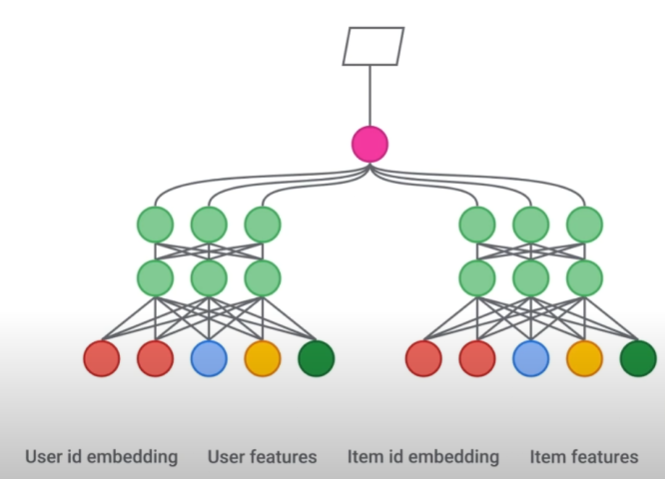

In [54]:
# ========================
# TWO TOWER MODEL
# ========================
class TwoTowerModel(tfrs.models.Model):
    def __init__(self, user_model, movie_model, movie_features):
        super().__init__()
        self.user_model = user_model
        self.movie_model = movie_model

        self.query_model = models.Sequential([
            self.user_model,
            layers.Dense(64, activation="relu"),
            layers.Dense(32, activation="relu"),
            layers.Dense(32)
        ])

        self.candidate_model = models.Sequential([
            self.movie_model,
            layers.Dense(64, activation="relu"),
            layers.Dense(32, activation="relu"),
            layers.Dense(32)
        ])

        metrics = tfrs.metrics.FactorizedTopK(
            candidates=movie_features.batch(128).map(self.candidate_model)
        )
        self.task = tfrs.tasks.Retrieval(metrics=metrics)

    def call(self, features):  # <-- Add this
        user_embeddings = self.query_model({
            "userId": features["userId"],
            "movieId": features["movieId"],
            "rating": features["rating"]
        })

        movie_embeddings = self.candidate_model({
            "movieId": features["movieId"],
            "genres": features["genres"]
        })

        return user_embeddings, movie_embeddings

    def compute_loss(self, features, training=False):
        user_embeddings, movie_embeddings = self(features)
        return self.task(user_embeddings, movie_embeddings)

In [55]:
# ========================
# MOVIE FEATURES FOR CANDIDATE SET
# ========================
def get_movie_features(dataset):
    return dataset.map(lambda x: {
        "movieId": x["movieId"],
        "genres": x["genres"]
    })

**Splitting the data for training, validation and testing**

In [56]:
def train_test_split(dataset):
    if isinstance(dataset, pd.DataFrame):
        dataset = tf.data.Dataset.from_tensor_slices(dict(dataset))

    size = dataset.cardinality().numpy()
    tf.random.set_seed(42)
    shuffled = dataset.shuffle(size, seed=42, reshuffle_each_iteration=False)

    train_size = round(size * 0.7)
    val_size = round((size - train_size) * 0.1)
    test_size = size - train_size - val_size

    train = shuffled.take(train_size).shuffle(train_size).batch(8192).cache()
    validation = shuffled.skip(train_size).take(val_size).batch(4096).cache()
    test = shuffled.skip(train_size + val_size).take(test_size).batch(4096).cache()

    return train, validation, test

**Visualization of Model training**

In [57]:
import matplotlib.pyplot as plt

def visualisation(model):
    # Plot Accuracy and Loss (Traning and Validation)
    # Accuracy
    plt.plot(model.history.history["factorized_top_k/top_100_categorical_accuracy"], label="train_accuracy")
    plt.plot(model.history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="val_accuracy")
    plt.legend()
    plt.title("Train and Validation Accuracy")
    plt.show()
    plt.close()

    # Loss
    plt.plot(model.history.history["total_loss"], label="train_loss")
    plt.plot(model.history.history["val_total_loss"], label="val_loss")
    plt.title("Train and Validation Loss")
    plt.legend()
    plt.title("Train and Validation Loss")
    plt.show()
    plt.close()

**Training the model**

In [58]:
user_model = UserTower(ratings_tf, embedding_dim=64)  # Initalizing the user tower
movie_model = CandidateTower(movies_tf, embedding_dim=64) # Initalizing the candidate tower
movie_features = get_movie_features(movies_tf) # Retrieving Moive features

train, validation, test = train_test_split(ratings_tf) # Splitting the data

model = TwoTowerModel(user_model, movie_model, movie_features) # Initializing the 2 Towers

print("**** Initializing Training ****\n")
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))
model.fit(train, epochs=20, validation_data=validation) # Model training
print("+++++++ Training COMPLETED +++++++")

**** Initializing Training ****

Epoch 1/20
9/9 [==============================] - 99s 11s/step - factorized_top_k/top_1_categorical_accuracy: 8.0754e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0034 - factorized_top_k/top_10_categorical_accuracy: 0.0065 - factorized_top_k/top_50_categorical_accuracy: 0.0244 - factorized_top_k/top_100_categorical_accuracy: 0.0450 - loss: 97049.6195 - regularization_loss: 0.0000e+00 - total_loss: 97049.6195 - val_factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_5_categorical_accuracy: 0.0017 - val_factorized_top_k/top_10_categorical_accuracy: 0.0026 - val_factorized_top_k/top_50_categorical_accuracy: 0.0238 - val_factorized_top_k/top_100_categorical_accuracy: 0.0370 - val_loss: 24385.0215 - val_regularization_loss: 0.0000e+00 - val_total_loss: 24385.0215
Epoch 2/20
9/9 [==============================] - 87s 10s/step - factorized_top_k/top_1_categorical_accuracy: 2.8335e-04 - factorized_top_k/top_5_categorical_ac

**Evaluation**

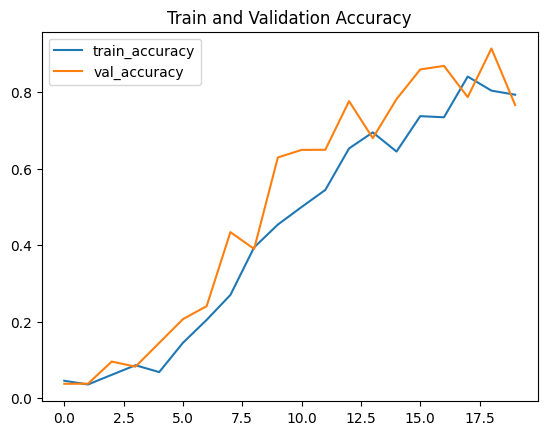

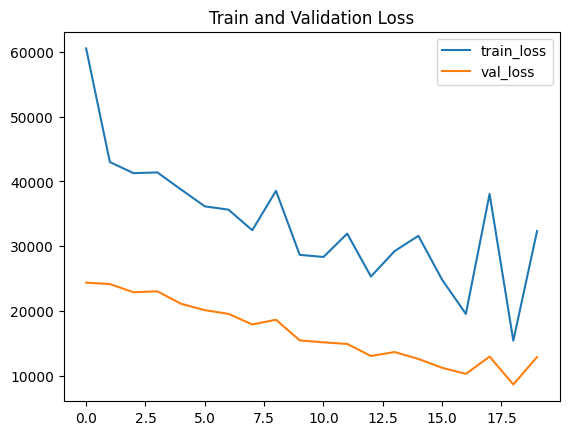

7/7 [==============================] - 34s 5s/step - factorized_top_k/top_1_categorical_accuracy: 0.0699 - factorized_top_k/top_5_categorical_accuracy: 0.2840 - factorized_top_k/top_10_categorical_accuracy: 0.3927 - factorized_top_k/top_50_categorical_accuracy: 0.6563 - factorized_top_k/top_100_categorical_accuracy: 0.7604 - loss: 17048.8108 - regularization_loss: 0.0000e+00 - total_loss: 17048.8108
Train Accuracy: 0.7931
Test Accuracy: 0.7604
Validation Accuracy: 0.7666


In [59]:
# Visualisation
visualisation(model)

# Evaluate on the Model
train_accy = model.evaluate(train, return_dict=True)["factorized_top_k/top_100_categorical_accuracy"]
val_accy = model.evaluate(validation, return_dict=True)["factorized_top_k/top_100_categorical_accuracy"]
test_accy = model.evaluate(test, return_dict=True)["factorized_top_k/top_100_categorical_accuracy"]

print(f"Train Accuracy: {train_accy:.4f}")
print(f"Test Accuracy: {test_accy:.4f}")
print(f"Validation Accuracy: {val_accy:.4f}")

**Inference**

In [60]:
import tensorflow_recommenders as tfrs
import tensorflow as tf

# Build the top-k retrieval layer
index = tfrs.layers.factorized_top_k.BruteForce(model.query_model)

index.index_from_dataset(
    movie_features.batch(128).map(lambda x: (
        x["movieId"],
        model.candidate_model(x)
    ))
)

# Example user data (replace with real values)
sample_user = {
    "userId": tf.constant([10]),         # an example userId
    "movieId": tf.constant([1]),         # dummy movieId just to match input shape
    "rating": tf.constant([4.0])         # dummy rating
}

# Top-5 recommendations
scores, movie_ids = index(sample_user, k=5)

print("Top 5 recommended movie IDs:", movie_ids.numpy()[0])

Top 5 recommended movie IDs: [  4886      1   3114 166461   2064]


**Saving the model**

In [61]:
# Save only the inference model
index.save("two_tower_index")

**Inference with saved model**

In [62]:
loaded_index = tf.keras.models.load_model("two_tower_index")

movie_id_to_title = dict(zip(movies["movieId"], movies["title"]))

# Recommendation function
def retrieve_recommendations(user_id, movie_id=5, rating=3.5):
    query_dict = {
        "userId": tf.constant([user_id], dtype=tf.int32),
        "movieId": tf.constant([movie_id], dtype=tf.int32),
        "rating": tf.constant([rating], dtype=tf.float32)
    }

    scores, movie_ids = loaded_index(query_dict)
    return movie_ids.numpy()[0], scores.numpy()[0]

recommended_movie_ids, scores = retrieve_recommendations(user_id=10)

# Map to titles
recommended_titles = [movie_id_to_title.get(mid, f"Movie {mid}") for mid in recommended_movie_ids]

print("Top Recommended Movie IDs:", recommended_movie_ids)
print("Scores:", scores)
print("Top Recommended Titles:", recommended_titles)

Top Recommended Movie IDs: [  8195   6545  31921 167706  69394   3475 160289 179133  97860  25855]
Scores: [-2.1684237 -2.197692  -2.3054225 -2.3463678 -2.3470287 -2.3493276
 -2.4016328 -2.4184563 -2.422852  -2.4473178]
Top Recommended Titles: ["Avventura, L' (Adventure, The) (1960)", 'I Capture the Castle (2003)', 'Seven-Per-Cent Solution, The (1976)', 'Shakespeare Behind Bars (2005)', 'Stoning of Soraya M., The (2008)', 'Place in the Sun, A (1951)', 'O.J.: Made in America (2016)', 'Loving Vincent (2017)', 'Killing Them Softly (2012)', 'Roaring Twenties, The (1939)']


**Inference with saved model and with unknown UserId / New UserId**

In [63]:
loaded_index = tf.keras.models.load_model("two_tower_index")

movie_id_to_title = dict(zip(movies["movieId"], movies["title"]))

# Recommendation function
def retrieve_recommendations(user_id, movie_id=5, rating=5):
    query_dict = {
        "userId": tf.constant([user_id], dtype=tf.int32),
        "movieId": tf.constant([movie_id], dtype=tf.int32),
        "rating": tf.constant([rating], dtype=tf.float32)
    }

    scores, movie_ids = loaded_index(query_dict)
    return movie_ids.numpy()[0], scores.numpy()[0]

recommended_movie_ids, scores = retrieve_recommendations(user_id=999) # New Usere ID
# Map to titles
recommended_titles = [movie_id_to_title.get(mid, f"Movie {mid}") for mid in recommended_movie_ids]

print("Top Recommended Movie IDs:", recommended_movie_ids)
print("Scores:", scores)
print("Top Recommended Titles:", recommended_titles)

Top Recommended Movie IDs: [167706   8195  31921   6545  65188  97860   6862 179133 103137   3475]
Scores: [-2.2103877 -2.23212   -2.291629  -2.351706  -2.3540597 -2.3585994
 -2.367463  -2.390608  -2.4408154 -2.4484901]
Top Recommended Titles: ['Shakespeare Behind Bars (2005)', "Avventura, L' (Adventure, The) (1960)", 'Seven-Per-Cent Solution, The (1976)', 'I Capture the Castle (2003)', 'Dear Zachary: A Letter to a Son About His Father (2008)', 'Killing Them Softly (2012)', 'Out of Time (2003)', 'Loving Vincent (2017)', 'Bling Ring, The (2013)', 'Place in the Sun, A (1951)']


**Optimization by using Scann**

**ScaNN:** Uses approximate nearest neighbor techniques (quantization, partitioning, tree search) to get fast and efficient top-k retrieval, often with near-identical accuracy.